In [1]:
import re
import os
import pathlib
import json

import plotnine
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")


In [2]:
experiment = "01_http_max_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()
results_dir


PosixPath('/Users/richardbieringa/Projects/mesh-bench/results/01_http_max_throughput')

In [122]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""



# Regex to extra# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

# Traverse all files in the results directory and construct dataframes form them
dfs = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Extract metadata from the result
        matches = re.match(name_re, file)

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        with open(p) as f:
            data = json.loads(f.read())
            
            # Transform the flattened json into a dataframe
            df = pd.json_normalize(data)
            df["mesh"] = matches[2]
            df["payload"] = matches[4]
            df["repetition"] = matches[5]

            dfs.append(df)

df = pd.concat(dfs)
df

Parsing Experiment results:
Exp: 01_http_max_throughput
Results: 25


,RunType,Labels,StartTime,RequestedQPS,RequestedDuration,ActualQPS,ActualDuration,NumThreads,Version,Exactly,...,HeaderSizes.Min,HeaderSizes.Max,HeaderSizes.Sum,HeaderSizes.Avg,HeaderSizes.StdDev,HeaderSizes.Data,HeaderSizes.Percentiles,mesh,payload,repetition
0,HTTP,,2022-06-12T14:31:28.384812039Z,max,10m0s,565.151631,600067276129,32,1.28.0,0,...,75,75,25434675,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,traefik,0,3
0,HTTP,,2022-06-12T13:58:20.928460602Z,max,10m0s,4904.844412,600003741777,32,1.28.0,0,...,209,210,615079995,209.002946,0.054198,"[{'Start': 209, 'End': 210, 'Percent': 100, 'C...",None,istio,0,5
0,HTTP,,2022-06-12T13:28:20.317549217Z,max,10m0s,4913.836228,600002495653,32,1.28.0,0,...,209,210,616205631,209.002715,0.052036,"[{'Start': 209, 'End': 210, 'Percent': 100, 'C...",None,istio,0,2
0,HTTP,,2022-06-12T12:44:30.55607617Z,max,10m0s,11499.706401,600002448682,32,1.28.0,0,...,75,75,517488900,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,linkerd,0,3
0,HTTP,,2022-06-12T12:24:30.158244439Z,max,10m0s,11456.248625,600003476253,32,1.28.0,0,...,75,75,515534175,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,linkerd,0,1
0,HTTP,,2022-06-12T15:50:13.324269143Z,max,10m0s,21281.654675,600002358610,32,1.28.0,0,...,75,75,957678225,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,cilium,0,5
0,HTTP,,2022-06-12T10:58:22.869262366Z,max,10m0s,25180.428357,600001985110,32,1.28.0,0,...,75,75,1133123025,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,1
0,HTTP,,2022-06-12T14:41:28.694553015Z,max,10m0s,570.605233,600057588093,32,1.28.0,0,...,75,75,25679700,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,traefik,0,4
0,HTTP,,2022-06-12T15:10:12.197840034Z,max,10m0s,21105.985743,600002679527,32,1.28.0,0,...,75,75,949773600,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,cilium,0,1
0,HTTP,,2022-06-12T13:18:20.107473828Z,max,10m0s,4874.675693,600014890118,32,1.28.0,0,...,209,210,611308584,209.003105,0.055637,"[{'Start': 209, 'End': 210, 'Percent': 100, 'C...",None,istio,0,1


In [4]:
""""
Filtering of the data by only including the fields that are used in the analysis.
"""

# TODO: Does it really matter?
print(list(df.columns))

['RunType', 'Labels', 'StartTime', 'RequestedQPS', 'RequestedDuration', 'ActualQPS', 'ActualDuration', 'NumThreads', 'Version', 'Exactly', 'Jitter', 'Uniform', 'NoCatchUp', 'RunID', 'AccessLoggerInfo', 'Insecure', 'CACert', 'Cert', 'Key', 'UnixDomainSocket', 'URL', 'NumConnections', 'Compression', 'DisableFastClient', 'HTTP10', 'DisableKeepAlive', 'AllowHalfClose', 'FollowRedirects', 'Resolve', 'HTTPReqTimeOut', 'UserCredentials', 'ContentType', 'Payload', 'LogErrors', 'ID', 'SequentialWarmup', 'SocketCount', 'AbortOn', 'DurationHistogram.Count', 'DurationHistogram.Min', 'DurationHistogram.Max', 'DurationHistogram.Sum', 'DurationHistogram.Avg', 'DurationHistogram.StdDev', 'DurationHistogram.Data', 'DurationHistogram.Percentiles', 'ErrorsDurationHistogram.Count', 'ErrorsDurationHistogram.Min', 'ErrorsDurationHistogram.Max', 'ErrorsDurationHistogram.Sum', 'ErrorsDurationHistogram.Avg', 'ErrorsDurationHistogram.StdDev', 'ErrorsDurationHistogram.Data', 'ErrorsDurationHistogram.Percentiles'

In [5]:
"""
Aggregate the data from observations sharing the configuration.
The seperate measurements were taken to ensure that data was consistent across multiple observations.

In this step we merge the data by providing aggregator functions per variable.
"""

# Construct aggregator functions (default to take first)
aggregator = {}
for key in df.columns: 
    aggregator[key] = "first"


# Overwrite aggregators
overwrite = {
    "ActualDuration": "mean",
    "ActualQPS": "mean",
    "repetition": "count",
    "DurationHistogram.Count": "sum",
    "DurationHistogram.Min": "mean",
    "DurationHistogram.Max": "mean",
    "DurationHistogram.Sum": "mean",
    "DurationHistogram.Avg": "mean",
    "DurationHistogram.StdDev": "mean",
    "DurationHistogram.Data": "sum",
    "ErrorsDurationHistogram.Count": "sum",
    "ErrorsDurationHistogram.Min": "mean",
    "ErrorsDurationHistogram.Max": "mean",
    "ErrorsDurationHistogram.Sum": "mean",
    "ErrorsDurationHistogram.Avg": "mean",
    "ErrorsDurationHistogram.StdDev": "mean",
    "ErrorsDurationHistogram.Data": "sum",
}

for key, value in overwrite.items():
    aggregator[key] = value

# Merge the fields based on the mesh configuration and apply the aggregator
# functions to aggregate the variables of each observation
aggregated_df = df.groupby("mesh").aggregate(aggregator)
aggregated_df

,RunType,Labels,StartTime,RequestedQPS,RequestedDuration,ActualQPS,ActualDuration,NumThreads,Version,Exactly,...,HeaderSizes.Min,HeaderSizes.Max,HeaderSizes.Sum,HeaderSizes.Avg,HeaderSizes.StdDev,HeaderSizes.Data,HeaderSizes.Percentiles,mesh,payload,repetition
mesh,,,,,,,,,,,,,,,,,,,,,
baseline,HTTP,,2022-06-12T10:58:22.869262366Z,max,10m0s,25019.497379,6.000018e+11,32,1.28.0,0,...,75,75,1133123025,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,5
cilium,HTTP,,2022-06-12T15:50:13.324269143Z,max,10m0s,21223.002674,6.000027e+11,32,1.28.0,0,...,75,75,957678225,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,cilium,0,5
istio,HTTP,,2022-06-12T13:58:20.928460602Z,max,10m0s,4897.250102,6.000062e+11,32,1.28.0,0,...,209,210,615079995,209.002946,0.054198,"[{'Start': 209, 'End': 210, 'Percent': 100, 'C...",None,istio,0,5
linkerd,HTTP,,2022-06-12T12:44:30.55607617Z,max,10m0s,11458.877746,6.000027e+11,32,1.28.0,0,...,75,75,517488900,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,linkerd,0,5
traefik,HTTP,,2022-06-12T14:31:28.384812039Z,max,10m0s,565.264404,6.000416e+11,32,1.28.0,0,...,75,75,25434675,75.000000,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,traefik,0,5


In [6]:
# Numpy random generator to generate random numbers from
# Certain distributions
rng = np.random.default_rng()


t = aggregated_df[aggregated_df["mesh"] == "baseline"]
d = t["DurationHistogram.Data"][0]

samples = []
for obs in d:
    samples.append(rng.uniform(low = obs["Start"], high = obs["End"], size = obs["Count"]))

n = np.concatenate(samples)
n.size

75058724

In [12]:
x = np.array([x["Start"] for x in d])
y = np.array([x["Count"] for x in d])
bins = [(x["Start"], x["End"]) for x in d]
bins2 = [x["Start"] for x in d]

bins2

[3.8234e-05,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.011,
 0.012,
 0.014,
 0.016,
 0.018000000000000002,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.045,
 4.0398e-05,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.011,
 0.012,
 0.014,
 0.016,
 0.018000000000000002,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 3.9026e-05,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.011,
 0.012,
 0.014,
 0.016,
 0.018000000000000002,
 0.02,
 0.025,
 0.03,
 3.9137e-05,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.011,
 0.012,
 0.014,
 0.016,
 0.018000000000000002,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.045,
 0.05,
 0.06,
 3.6275e-05,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.011,
 0.012,
 0.014,
 0.016,
 0.018000000000000002,
 0.02,
 0.025,
 0.03,
 0.03

In [133]:
print("Orig:")
print(t["DurationHistogram.Avg"].item())
print(t["DurationHistogram.Count"].item())
print(t["DurationHistogram.Max"].item())
print(t["DurationHistogram.Min"].item())
print(t["DurationHistogram.StdDev"].item())

print("Sampled:")
print(np.average(n))
print(len(n))
print(np.max(n))
print(np.min(n))
print(np.std(n))

Orig:
0.0012788422628954889
75058724
0.0450000116
3.8614e-05
0.0011975422862158661
Sampled:
0.0013487228246095138
75058724
0.0604418724253063
3.627519438037573e-05
0.001237321371592015


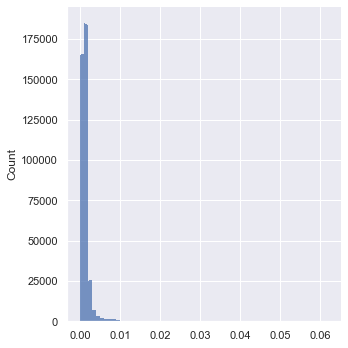

In [125]:
sns.displot(n)

In [111]:
t = np.random.uniform(low=0, high=1, size=10)
t.mean()


0.5912478321775186

In [127]:
# First baseline result
baseline = df[df["mesh"] == "baseline"]
baseline

,RunType,Labels,StartTime,RequestedQPS,RequestedDuration,ActualQPS,ActualDuration,NumThreads,Version,Exactly,...,HeaderSizes.Min,HeaderSizes.Max,HeaderSizes.Sum,HeaderSizes.Avg,HeaderSizes.StdDev,HeaderSizes.Data,HeaderSizes.Percentiles,mesh,payload,repetition
0,HTTP,,2022-06-12T10:58:22.869262366Z,max,10m0s,25180.428357,600001985110,32,1.28.0,0,...,75,75,1133123025,75.0,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,1
0,HTTP,,2022-06-12T11:18:23.242641206Z,max,10m0s,25153.573137,600001634669,32,1.28.0,0,...,75,75,1131913875,75.0,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,3
0,HTTP,,2022-06-12T11:38:23.603240321Z,max,10m0s,24618.106528,600001303247,32,1.28.0,0,...,75,75,1107817200,75.0,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,5
0,HTTP,,2022-06-12T11:28:23.417645854Z,max,10m0s,24916.326695,600001163203,32,1.28.0,0,...,75,75,1121236875,75.0,0.000001,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,4
0,HTTP,,2022-06-12T11:08:23.057296447Z,max,10m0s,25229.052178,600003158797,32,1.28.0,0,...,75,75,1135313325,75.0,0.000000,"[{'Start': 75, 'End': 75, 'Percent': 100, 'Cou...",None,baseline,0,2


<AxesSubplot:xlabel='Start', ylabel='Count'>

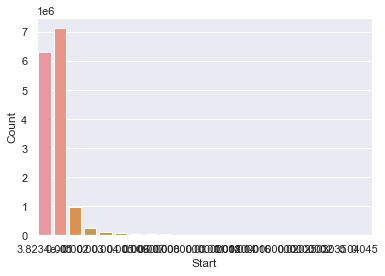

In [119]:
data = baseline["DurationHistogram.Data"]
data


bins = [x["Start"] for x in data]
bins.append(data[-1]["End"])
bins = np.array(bins)
bins = bins * 1000

counts = np.array([x["Count"] for x in data])
counts

# start = [x["Start"] * 1000 for x in data]
# end = [x["End"] * 1000 for x in data]
# counts = [x["Count"] for x in data]

# df = pd.DataFrame({"start": start, "end": end, "counts": counts})
# df["bin"] = df["start"].astype(str) + df["end"].astype(str) 
# df


data = pd.DataFrame(data)

fix,ax = plt.subplots()
plt.hist(counts, bins = bins)
sns.barplot(x='Start', y='Count', data=data)

<AxesSubplot:xlabel='bin', ylabel='epa'>

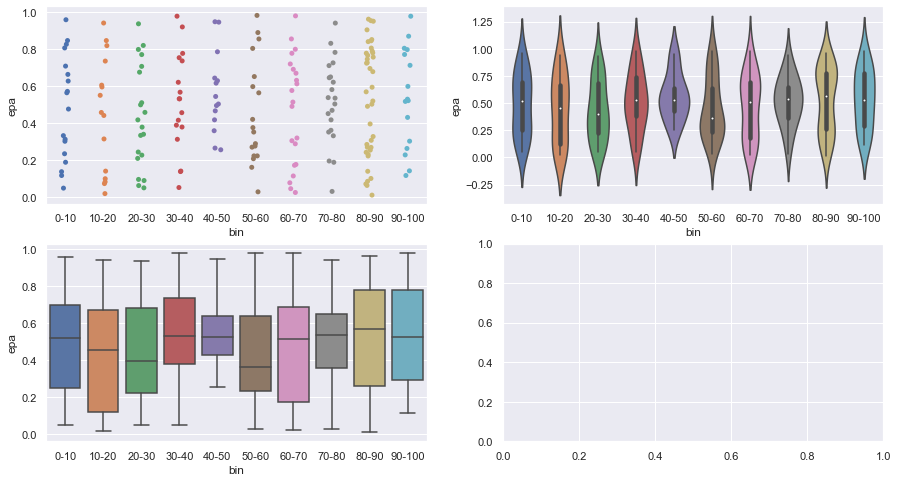

In [70]:
df = pd.DataFrame({'yardline_100':np.random.randint(0,100,200), 'epa':np.random.random(200)})
df['bin'] = pd.cut(df['yardline_100'], bins=range(0,101,10), labels=[f'{l}-{l+10}' for l in range(0,91,10)])

fig,ax = plt.subplots(2,2, figsize=(15,8))
ax=ax.flatten()
sns.stripplot(x='bin', y='epa', data=df, ax=ax[0])
sns.violinplot(x='bin', y='epa', data=df, ax=ax[1])
sns.boxplot(x='bin', y='epa', data=df, ax=ax[2])

In [71]:
df

,yardline_100,epa,bin
0,64,0.175977,60-70
1,8,0.116187,0-10
2,26,0.937567,20-30
3,31,0.378619,30-40
4,85,0.062388,80-90
...,...,...,...
195,62,0.777884,60-70
196,60,0.160528,50-60
197,30,0.061644,20-30
198,95,0.978612,90-100
